In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from numpy.random import default_rng
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
from scipy.stats import norm, chi2

orig_path= "/Users/sebhoof/Research/BHSR/"

#sys.path.append("../code_matt/")
rng = default_rng()

#from BH_functions import stellar_functions

from plot_style import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *

!mkdir -p figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Examples for solar BH mass and spin samples

In [5]:
phi = np.linspace(0, 2*np.pi, 100)

# The function below plots processed samples, so we first need to format with the raw data
def plot_m_a(m, a, label='', mfit=[1,0], afit=[0.5,0]):
    plt.figure(figsize=(3.375,3))
    plt.plot(m, a, 'o', ms=1, c='0.6', rasterized=True)
    m_mean, a_mean = np.mean(m), np.mean(a)
    m_std, a_std = np.std(m), np.std(a)
    cov = np.cov((m,a))
    l, c = np.linalg.eig(cov)
    #plt.plot(2*[mfit[0]], [afit[0]-afit[1],afit[0]+afit[1]], 'r-')
    #plt.plot([mfit[0]-mfit[1],mfit[0]+mfit[1]], 2*[afit[0]], 'r-')
    print("m = {:.2f} +/- {:.2f}, a = {:.2f} +/- {:.2f}".format(m_mean, m_std, a_mean, a_std))
    xp = np.array([2*c@np.diag(np.sqrt(l))@v for v in [np.array([np.cos(x), np.sin(x)]).T for x in phi]])
    plt.plot(m_mean + 2*m_std*np.cos(phi), a_mean + 2*a_std*np.sin(phi), 'b--')
    plt.plot(m_mean + xp[:,0], a_mean + xp[:,1], 'r-')
    plt.plot(m_mean+2*m_std*np.array([1,1,-1,-1,1]), a_mean+2*a_std*np.array([1,-1,-1,1,1]), 'k:')
    plt.ylim([0,1])
    plt.xlim([5,25])
    plt.xlabel(r"BH mass [$M_\odot$]")
    plt.ylabel(r"BH spin $a_\ast$")
    plt.text(24, 0.1, label, ha='right', va='center')
    if label !='':
        plt.tight_layout(pad=0.25)
        plt.savefig("figures/"+label+".pdf", backend='pgf')
    plt.show()

m = 14.77 +/- 0.95, a = 1.00 +/- 0.01


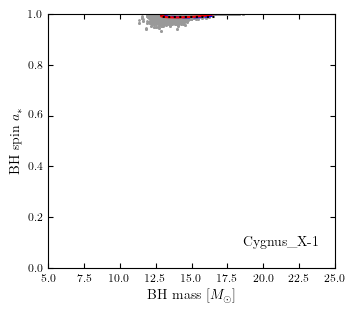

In [6]:
# Cygnus X-1
# See https://ui.adsabs.harvard.edu/abs/2011ApJ...742...85G

cygX1_m = []
cygX1_a = []
for i in range(3):
   dat = np.genfromtxt("data/raw/solar/Cygnus_X-1/sp{:d}.txt".format(i+1))
   cygX1_m.append(dat[:,1])
   cygX1_a.append(dat[:,4])
cygX1_m = np.concatenate(cygX1_m)
cygX1_a = np.concatenate(cygX1_a)

plot_m_a(cygX1_m, cygX1_a, label='Cygnus_X-1',)

m = 15.67 +/- 1.49, a = 0.83 +/- 0.06


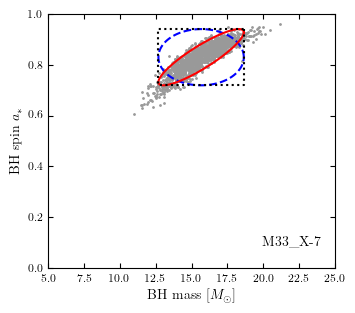

In [7]:
# M33_X-7
data = np.genfromtxt("data/raw/solar/M33_X-7/f3_data_tex.txt")
m33x7_a0 = 0.77 + 0.068
a0 = data[:,0]
m0 = data[:,1]
m33x7_a = -0.2 + (a0-154.560)*(0.1+0.2)/(369.920-154.560) + m33x7_a0
m33x7_m = 12 + (m0-665.600)*(20-12)/(880.960-665.600)

plot_m_a(m33x7_m, m33x7_a, label='M33_X-7', mfit=[15.65,1.45], afit=[0.84,0.05])

m = 11.10 +/- 1.53, a = 0.60 +/- 0.16


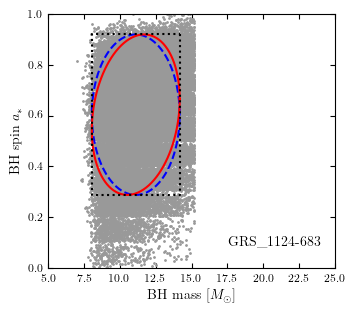

In [8]:
# Nova_Muscae_1991 aka GRS 1124-683
nm_files = !ls {orig_path}bh_data/raw/Nova_Muscae_1991/*npy
nm91_m, nm91_a = [], []
for nmf in nm_files:
   dat = np.load(nmf)
   nm91_m.append(dat[:,1])
   nm91_a.append(dat[:,6])
nm91_m = np.concatenate(nm91_m)
nm91_a = np.concatenate(nm91_a)

plot_m_a(nm91_m, nm91_a, label='GRS_1124-683', mfit=[11.0,1.4], afit=[0.63,0.16])

### Some other plots for M33 X-7

In [6]:
ma_test = 7e-12
states = np.array([(i,j,j) for i in range(7) for j in range(1,i)])

In [7]:
import warnings

m_bh_vals = np.arange(-1, 2, 0.02)
a_vals_1 = []
a_vals_2 = []

def foo(a0, mbh, ma, n=2, l=1, m=1):
    return GammaSR_nlm_mod(ma, mbh, a0, n, l, m) - inv_tSR

for mbh in 10**m_bh_vals:
    with warnings.catch_warnings(record=True) as w:
        res = root_scalar(foo, x0=0, x1=0.5, args=(mbh, 4.3e-12))
        if len(w) == 0:
            a_vals_1.append(res.root)
        else:
            a_vals_1.append(np.nan)
    temp = []
    for s in states:
        with warnings.catch_warnings(record=True) as w:
            res = root_scalar(foo, x0=0, x1=0.5, args=(mbh, ma_test, *s))
            if len(w) == 0:
                temp.append(res.root)
            else:
                temp.append(np.nan)
    a_vals_2.append(temp)
a_vals_2 = np.array(a_vals_2)

In [8]:
n_samples_ref = 100000
astar_ref, lgm_ref = rng.normal(loc=0.84, scale=0.05, size=n_samples_ref), np.log10(rng.normal(loc=15.56, scale=1.45, size=n_samples_ref))

In [9]:
mc_test = []
mc_gammas = []
for m,a in zip(m33x7_m, m33x7_a):
    check = 1
    for s in states:
        gam = GammaSR_nlm_mod(ma_test, m, a, *s)
        if s[0] == 2:
            mc_gammas.append(gam/inv_tSR)
        if gam > inv_tSR:
            check = 0
            break
    mc_test.append(check)
p_ex_mc = 100*(1.0-sum(mc_test)/len(mc_test))
print('P_ex = {:.2f}%'.format(p_ex_mc))

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/fractions.py:401: RuntimeWarning: overflow encountered in long_scalars
  return Fraction(a.numerator * b.numerator, a.denominator * b.denominator)


P_ex = 99.95%


In [10]:
mc_crosscheck = []
mc_gammas_crosscheck = []
for m,a in zip(10**lgm_ref,astar_ref):
    check = 1
    for s in states:
        gam = GammaSR_nlm_mod(ma_test, m, a, *s)
        if s[0] == 2:
            mc_gammas_crosscheck.append(gam/inv_tSR)
        if gam > inv_tSR:
            check = 0
            break
    mc_crosscheck.append(check)
p_ex_mc_gauss = 100*(1.0-sum(mc_crosscheck)/len(mc_crosscheck))
print('P_ex = {:.2f}%'.format(p_ex_mc_gauss))

/Users/sebhoof/Software/bhsr/py/bhsr.py:55: RuntimeWarning: invalid value encountered in sqrt
  marp = al*(1 + np.sqrt(1-astar*astar))


P_ex = 99.92%


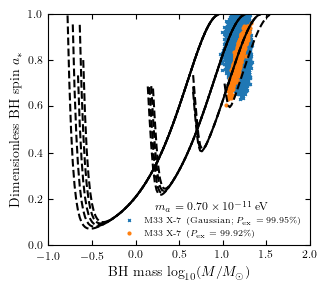

In [11]:
cond = (m_bh_vals > 0)

fig, ax = plt.subplots()

# ax.plot(m_bh_vals, a_vals_1, 'k')
ax.plot(lgm_ref, astar_ref, 'x', ms=2, label=r'M33 X-7 (Gaussian; $P_\mathrm{{ex}} = {:.2f}\%$)'.format(p_ex_mc), rasterized=True)
ax.plot(np.log10(m33x7_m), m33x7_a, 'o', ms=2, label='M33 X-7 ($P_\mathrm{{ex}} = {:.2f}\%$)'.format(p_ex_mc_gauss), rasterized=True)
for i,s in enumerate(states):
    ax.plot(m_bh_vals, a_vals_2[:,i], 'k--') #, label='$|{:d}{:d}{:d}\\rangle$'.format(*s))

ax.set_xlabel('BH mass $\log_{10}(M/M_\odot)$')
ax.set_ylabel('Dimensionless BH spin $a_*$')
ax.set_ylim([0,1])
ax.set_xlim([-1,2])

leg = ax.legend(frameon=False, loc=4, title='$m_a = {}\,$eV'.format(sci_format(ma_test)), fontsize=6)
#leg.get_title().set_fontsize('8')

fig.tight_layout()
fig.savefig("figures/regge_slope.pdf", dpi=300, backend='pgf')
plt.show()

/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/2091516363.py:3: RuntimeWarning: All-NaN slice encountered
  approx_regge_slope = interp1d(10**m_bh_vals, [np.nanmin(a) for a in a_vals_2])


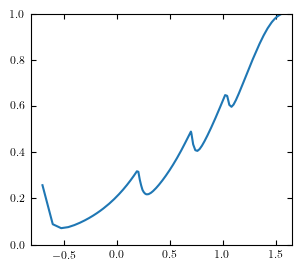

0.9575457035853819 0.978772851792691
P_ex = 99.95% (full MC) 99.92% (MC Gauss) 97.88% (Matt's formula) 99.89% (Matt's code)


In [12]:
# Calc from formalism 

approx_regge_slope = interp1d(10**m_bh_vals, [np.nanmin(a) for a in a_vals_2])

# 0.84 +/- 0.05, 15.56 +/- 1.45
x = np.linspace(0.1, 50, 1000)
plt.plot(np.log10(x), approx_regge_slope(x))
plt.ylim([0,1])
plt.show()

fval = approx_regge_slope(15.56)
der = (approx_regge_slope(15.56+0.005)-approx_regge_slope(15.56-0.005))/0.01
eff_err = np.sqrt(0.05**2 + (der*1.45)**2)
c2 = ((0.84-fval)/eff_err)**2
p_ex_matts_eq = norm.cdf(np.sqrt(c2))
print(chi2.cdf(c2, 1), p_ex_matts_eq)

print('P_ex = {:.2f}% (full MC) {:.2f}% (MC Gauss) {:.2f}% (Matt\'s formula) {:.2f}% (Matt\'s code)'.format(p_ex_mc, p_ex_mc_gauss, 100*p_ex_matts_eq, 99.89))

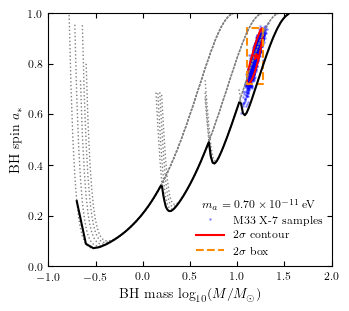

In [13]:
fig, ax = plt.subplots(figsize=(3.375,3))

#ax.plot(lgm_ref, astar_ref, 'x', ms=2, label=r'M33 X-7 (Gaussian; $P_\mathrm{{ex}} = {:.2f}\%$)'.format(p_ex_mc), rasterized=True)
ax.plot(np.log10(m33x7_m), m33x7_a, 'o', c='b', ms=1, label=r'M33 X-7 samples', alpha=0.3)#, rasterized=True)

m_mean, a_mean = np.mean(m33x7_m), np.mean(m33x7_a)
m_std, a_std = np.std(m33x7_m), np.std(m33x7_a)
cov = np.cov((m33x7_m,m33x7_a))
l, c = np.linalg.eig(cov)
xp = np.array([2*c@np.diag(np.sqrt(l))@v for v in [np.array([np.cos(x), np.sin(x)]).T for x in phi]])
#ax.plot(m_mean + 2*m_std*np.cos(phi), a_mean + 2*a_std*np.sin(phi), 'b--')
ax.plot(np.log10(m_mean + xp[:,0]), a_mean + xp[:,1], 'r-', label=r"2$\sigma$ contour")
ax.plot(np.log10(m_mean+2*m_std*np.array([1,1,-1,-1,1])), a_mean+2*a_std*np.array([1,-1,-1,1,1]),
        c='darkorange', ls='--', lw=1.5, label=r"2$\sigma$ box")


for i,s in enumerate(states):
    ax.plot(m_bh_vals, a_vals_2[:,i], ':', c='grey', lw=1) #, label='$|{:d}{:d}{:d}\\rangle$'.format(*s))

x = np.linspace(0.1, 50, 1000)
ax.plot(np.log10(x), approx_regge_slope(x), 'k-', lw=1.5)
    
ax.plot(np.log10(m_mean), a_mean, '*', c='r', ms=5)

ax.set_xlabel('BH mass $\log_{10}(M/M_\odot)$')
ax.set_ylabel(r'BH spin $a_\ast$')
ax.set_ylim([0,1])
ax.set_xlim([-1,2])

leg = ax.legend(frameon=False, handlelength=2.495, loc=4, title='$m_a = {}\,$eV'.format(sci_format(ma_test)), fontsize=8)
#leg.get_title().set_fontsize('8')

fig.tight_layout(pad=0.3)
fig.savefig("figures/regge_slopes_envelope.pdf", backend='pgf')
plt.show()

### Functions for $P_\text{ex}$

In [14]:
n_samples_ref = 100000

def get_gaussian_samples(m_mean, m_std, a_mean, a_std, n=n_samples_ref):
    return rng.normal(loc=m_mean, scale=m_std, size=n), rng.normal(loc=a_mean, scale=a_std, size=n)

cygX1_m_gauss, cygX1_a_gauss = get_gaussian_samples(14.8, 1.0, 1.0, (1.0-0.983)/3.0)
nm91_m_gauss, nm91_a_gauss = get_gaussian_samples(11.0, 1.4, 0.63, 0.16)

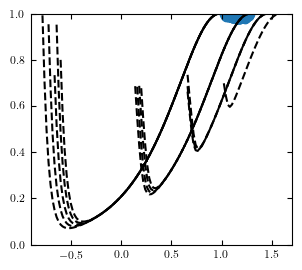

In [15]:
plt.scatter(np.log10(cygX1_m_gauss), cygX1_a_gauss)
for i,s in enumerate(states):
    plt.plot(m_bh_vals, a_vals_2[:,i], 'k--')
plt.ylim([0,1])
plt.show()

In [16]:
bh_names = ['Cygnus X-1', 'GRS 1124-683', 'M33 X-7']
bh_indices = {
    'Cygnus X-1': 2,
    'Cyg X-1': 2,
    'GRO J1655-40': 3, 
    'GRS1915+105': 4,
    'M33 X-7': 13,
    'LMC X-1': 11,
}

bh_data = { 'Cygnus X-1': (cygX1_m, cygX1_a), 'GRS 1124-683': (nm91_m, nm91_a), 'M33 X-7': (m33x7_m, m33x7_a) }
bh_gaussian_data = { 'Cygnus X-1': (cygX1_m_gauss, cygX1_a_gauss), 'GRS 1124-683': (nm91_m_gauss, nm91_a_gauss), 'M33 X-7': (10**lgm_ref, astar_ref) }

In [17]:
def mc_integration(mu, data, states):
    temp = []
    for m,a in zip(*data):
        check = 1
        a0 = np.minimum(1, a)
        for s in states:
            if GammaSR_nlm_mod(mu, m, a0, *s) > inv_tSR:
                check = 0
                break
        temp.append(check)
    p_ex = 100.0*(1.0-sum(temp)/len(temp))
    return p_ex

def get_excl_prob(mu, bh_name, states, out=True):
    p_ex_full = mc_integration(mu, bh_data[bh_name], states)
    p_ex_gauss = mc_integration(mu, bh_gaussian_data[bh_name], states)
    if out:
        print('{}: P_ex = {:.2f}% (Full MC), {:.2f}% (Gauss MC)'.format(bh_name, p_ex_full, p_ex_gauss))
    return p_ex_full, p_ex_gauss

"""
def get_excl_prob_matt(lgmu, bh_name, states):
    p_ex_matt = []
    for m in lgmu:
        try:
            temp = 100*stellar_functions[bh_indices[bh_name]](m,18)[0]
        except:
            temp = m # np.full_like(lgmu, fill_value=np.nan)
        p_ex_matt.append(temp)
    return np.array(p_ex_matt)

def get_excl_prob_all(mu, bh_name, states, out=True):
    p_ex_full = mc_integration(mu, bh_data[bh_name], states)
    p_ex_gauss = mc_integration(mu, bh_gaussian_data[bh_name], states)
    try:
        p_ex_matt = 100*stellar_functions[bh_indices[bh_name]](np.log10(mu),18)[0]
    except:
        p_ex_matt = np.nan
    if out:
        print('{}: P_ex = {:.2f}% (Full MC), {:.2f}% (Gauss MC), {:.2f}% (Matt\'s code)'.format(bh_name, p_ex_full, p_ex_gauss, p_ex_matt))
    return p_ex_full, p_ex_gauss, p_ex_matt
""";

table_string = ""
for bh in bh_names:
    p1, p2 = get_excl_prob(ma_test, bh, states)
    table_string += "{} & {:.2f} & {:.2f} \\\\\n".format(bh, p1, p2)
print(table_string)

Cygnus X-1: P_ex = 100.00% (Full MC), 100.00% (Gauss MC)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/fractions.py:401: RuntimeWarning: overflow encountered in long_scalars
  return Fraction(a.numerator * b.numerator, a.denominator * b.denominator)


GRS 1124-683: P_ex = 74.41% (Full MC), 77.62% (Gauss MC)
M33 X-7: P_ex = 99.95% (Full MC), 99.99% (Gauss MC)
Cygnus X-1 & 100.00 & 100.00 \\
GRS 1124-683 & 74.41 & 77.62 \\
M33 X-7 & 99.95 & 99.99 \\



### Trying to reproduce Masha's results

From [arXiv:1411.2263](https://arxiv.org/pdf/1411.2263.pdf)

In [18]:
masha_data = [
    ['M33 X-7', 3e6, 15.56, 1.45, 0.84, 0.1, 0.1],
    ['LMC X-1', 5e6, 10.91, 1.4, 0.92, 0.06, 0.18],
    ['GRO J1655-40', 3.4e8, 6.3, 0.5, 0.72, 0.16, 0.24],
    ['Cyg X-1', 4.8e6, 14.8, 1.0, 1.0, 0.0, 0.005],
    ['GRS1915+105', 4e9, 10.1, 0.6, 1.0, 0.0, 0.025]
]

In [19]:
lgmuvals = np.linspace(-13, -9, 200)
more_lgmuvals = np.linspace(-14, -9, 200)
lginvfvals = np.linspace(-20, -10, 100)

grid_x = [[m for m in lgmuvals] for _ in lginvfvals]
grid_y = [[f for _ in lgmuvals] for f in lginvfvals]
    

states = [(ell+1, ell, ell) for ell in range(1,6)]
    
def test_for_index_old(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    mbh_p, mbh_m = mbh+2*mbh_err, max(0,mbh-2*mbh_err)
    _, a_m = min(0.99, a+2*a_err_p), max(0, a-2*a_err_m)
    excluded = 0
    res = [0, 0]
    for s in states:
        n, l, m = s
        # Check SR condition
        if alpha(mu, mbh_m)/l <= 0.5:
            excluded += is_sr_mode(mu, mbh_m, a_m, tbh, n, l, m)
            #excluded *= is_sr_mode(mu, mbh_m, a_p, tbh, n, l, m)
            excluded *= not_bosenova_is_problem(mu, invf, mbh_m, a_m, tbh, n, l, m)
            res[0] = excluded
        if alpha(mu, mbh_p)/l <= 0.5:
            excluded += is_sr_mode(mu, mbh_p, a_m, tbh, n, l, m)
            #excluded *= is_sr_mode(mu, mbh_p, a_p, tbh, n, l, m)
            excluded *= not_bosenova_is_problem(mu, invf, mbh_p, a_m, tbh, n, l, m)
            res[1] = excluded
        #if excluded > 0:
        #    return 1
        if res[0]*res[1] > 0:
            return 1
    return 0

def test_for_index_new(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    mbh_p, mbh_m = mbh+2*mbh_err, max(0,mbh-2*mbh_err)
    a_p, a_m = min(0.99, a+2*a_err_p), max(0, a-2*a_err_m)
    excluded = 1
    sr_rates = []
    for s in states:
        n, l, m = s
        sr_rates.append([GammaSR_nlm_mod(mu, mbh_m, a_m, n, l, m),
                         GammaSR_nlm_mod(mu, mbh_m, a_p, n, l, m),
                         GammaSR_nlm_mod(mu, mbh_p, a_m, n, l, m),
                         GammaSR_nlm_mod(mu, mbh_p, a_p, n, l, m)])
    sr_rates = np.array(sr_rates)
    sr_rates_min = [np.nanmin(sr_rates[:,i]) for i in range(4)]
    indices = [np.where(sr_rates[:,i] == sr_rates_min[i])[0][0] for i in range(4)]
    n_min = [states[i][0] for i in indices]
    l_min = [states[i][1] for i in indices]
    for sr,n,l,m in zip(sr_rates_min,n_min,l_min,2*[mbh_m]+2*[mbh_p]):
        excluded *= is_sr_mode_min(mu, sr, m, tbh)*not_bosenova_is_problem_min(mu, sr, invf, m, tbh, n)
    return excluded

def test_for_index(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    sigma_level = 2
    mbh_p, mbh_m = mbh+sigma_level*mbh_err, max(0,mbh-sigma_level*mbh_err)
    _, a_m = min(0.99, a+sigma_level*a_err_p), max(0, a-sigma_level*a_err_m)
    # excluded = [0,0] 
    # TODO: make sure that we rule out the point if for mbh- any SR state exists,
    # and for mbh+ any (other) SR state exists
    for i,mm in enumerate(np.linspace(mbh_m, mbh_p, 20)):
        sr_rates = []
        sr_checks = []
        for s in states:
            n, l, m = s
            if (alpha(mu, mm)/l <= 0.5):
                sr = GammaSR_nlm_mod(mu, mm, a_m, n, l, m)
                #sr = GammaSR_nlm_1004(mu, mm, a_m, n, l, m)
                sr_rates.append(sr)
                sr_checks.append(is_sr_mode_min(mu, sr, mm, tbh)*not_bosenova_is_problem_min(mu, sr, invf, mm, tbh, n))
        if len(sr_rates) == 0:
            return 0
        #sr_rates_min = np.nanmax(sr_rates)
        #index = np.where(sr_rates == sr_rates_min)[0][0]
        #excluded[i] = sr_checks[index]
        if sum(sr_checks) == 0:
            return 0
    return 1

grid_z0 = [[test_for_index(0, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z1 = [[test_for_index(1, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z2 = [[test_for_index(2, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z3 = [[test_for_index(3, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z4 = [[test_for_index(4, m, f) for m in lgmuvals] for f in lginvfvals]

In [20]:
#matt_grids = np.array([get_excl_prob_matt(more_lgmuvals, masha_data[i][0], states)/100.0 for i in range(5)])

/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/3203530034.py:7: UserWarning: No contour levels were found within the data range.
  ax.contour(grid_x, grid_y, g, levels=[1], colors='r')


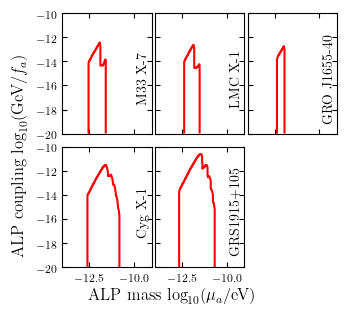

In [21]:
grids = [grid_z0, grid_z1, grid_z2, grid_z3, grid_z4]

fig, axes = plt.subplots(2, 3, figsize=(3.375,3), sharex=True, sharey=True)
#for g,gm,ax,m in zip(grids,matt_grids,axes.flat,masha_data):
for g,ax,m in zip(grids,axes.flat,masha_data):
    #ax.contourf(grid_x, grid_y, g)
    ax.contour(grid_x, grid_y, g, levels=[1], colors='r')
    ax.text(-9.5, -15.5, m[0], ha='center', va='center', rotation=90, c='k')
    ax.set_xlim([-14,-9])
    ax.set_ylim([-20,-10])
axes[-1,-1].axis('off')
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supxlabel(r"ALP mass $\log_{10}(\mu_a/\text{eV})$")
fig.supylabel(r"ALP coupling $\log_{10}(\text{GeV}/f_a)$")
fig.tight_layout(pad=0.25)
fig.savefig("figures/reproduced_exclusions_2d.pdf", backend='pgf')
plt.show()

In [22]:
# This is called the "non-relativistic approximation (see Fig. 5 in 1004.3558)"

def c_nl_1004(n, l):
    x = Fraction(factorial(2*l+n+1) * 2**(4*l+2), factorial(n) * (l+n+1)**(2*l+4) )
    y = Fraction(factorial(l), factorial(2*l+1)*factorial(2*l))
    return x*y*y

def c_nl_1004_float(n, l):
    c_nl_fr = c_nl_1004(n, l)
    return 1.0*c_nl_fr

def GammaSR_nlm_1004(ma, mbh, astar, n, l, m):
    al = alpha(ma, mbh)
    marp = al*(1 + np.sqrt(1-astar*astar))
    x = 2.0*(0.5*m*astar - marp)
    factors = [(k*k)*(1.0-astar*astar) + x*x for k in range(1,l+1)]
    return  ma*x * al**(4*(l+1)) * c_nl_1004_float(n, l) * prod(factors)

/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/194242673.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muvals, np.log10(GammaSR_nlm_mod(muvals, 10, 0.99, n, l, m)*rg(10)), 'r')
/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/194242673.py:10: RuntimeWarning: invalid value encountered in log10
  plt.plot(muvals, np.log10(GammaSR_nlm_mod(muvals, 10, 0.99, n, l, m)*rg(10)), 'r')
/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/194242673.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muvals, np.log10(GammaSR_nlm_1004(muvals, 10, 0.99, n, l, m)*rg(10)), 'b:')
/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/194242673.py:11: RuntimeWarning: invalid value encountered in log10
  plt.plot(muvals, np.log10(GammaSR_nlm_1004(muvals, 10, 0.99, n, l, m)*rg(10)), 'b:')


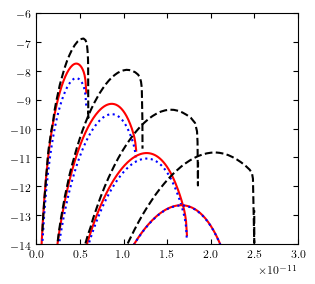

In [23]:
masha_bhsr_rates = []
for i in range(1,5):
    data = np.genfromtxt("data/1411_2263/ell_{:d}".format(i))
    data[:,1] = np.log10(data[:,1])
    masha_bhsr_rates.append(data)
    
muvals = np.linspace(0, 3, 300)*1e-11
for s in states:
    n, l, m = s
    plt.plot(muvals, np.log10(GammaSR_nlm_mod(muvals, 10, 0.99, n, l, m)*rg(10)), 'r')
    plt.plot(muvals, np.log10(GammaSR_nlm_1004(muvals, 10, 0.99, n, l, m)*rg(10)), 'b:')
for d in masha_bhsr_rates:
    plt.plot(d[:,0], d[:,1], 'k--')
plt.xlim([0,3e-11])
plt.ylim([-14,-6])
plt.show()

In [24]:
#from scipy.special import hyperu, hyp2f1
from sympy import symbols, diff, sqrt, exp
r = symbols('r')
from sympy import hyper
# 1004.3588
# U( , , ) hypergeometric function of 2nd kind aka Tricomi's (confluent hypergeometric) function
# 2F1( , , , ) Gauss's hypergeometric function

In [25]:
def sol_far(r, n, l, ma, mbh):
    al = alpha(ma, mbh)
    nn = n+l+1
    k = (al*ma/nn)**2 * (1 - (0.5*al/nn)**2)
    z = 2*k*r
    a = l+1-al**2/(k*rg(mbh))
    b = 2*(l+1)
    return z**l * exp(-0.5*z) * hyper((a,b), [], z)/ z**a

def sol_near(r, n, l, m, ma, mbh, astar):
    rp = r_plus(mbh, astar)
    rm = r_minus(mbh, astar)
    al = alpha(ma, mbh)
    nn = n+l+1
    p = 2*rp*(ma*(1-0.5*(al/nn)**2) - 0.5*(m/rg(mbh))*astar/(1 + sqrt(1-astar**2)) / (rp - rm))
    c = (r-rp)/(r-rm)
    return c**(-1j*p) * hyper((-l, l+1), [1+2j*p], c)

def residual_eq(n, l, m, ma, mbh, astar):
    f1 = sol_near(r, n, l, m, ma, mbh, astar)
    f2 = sol_far(r, n, l, ma, mbh)
    rp = r_plus(mbh, astar)
    rm = r_minus(mbh, astar)
    delta = (r-rp) * (r-rm)
    al = alpha(ma, mbh)
    nn = n+l+1
    om = ma*(1 - 0.5*(al/nn)**2)
    a = astar*rg(mbh)
    def eqop(f):
        term1 = diff(f, r)
        term2 = delta*diff(delta*term1, r)
        term3 = ma*r**2 + (a*om)**2 + l*(l+1)
        term4 = ( (r**2 + a**2)**2 * om**2 - 4*a*rg(mbh)*r*m*om + (m*a)**2 - delta*term3 )*f
        return term2 + term4
    # expr1 = lambdify(r, eqop(f1), "numpy")
    # expr2 = lambdify(r, eqop(f2), "numpy")
    # return expr1, expr2
    return eqop(f1), eqop(f2)

In [26]:
f1, f2 = residual_eq(2, 1, 1, 0.5e-11, 10, 0.99)
f1, f2 = f1.evalf(), f2.evalf()

In [27]:
rvals = np.linspace(1, 20, 150)*rg(mbh)
f1vals = [complex(f1.subs(r,rr)).real for rr in rvals]
f2vals = [complex(f2.subs(r,rr)).real for rr in rvals]

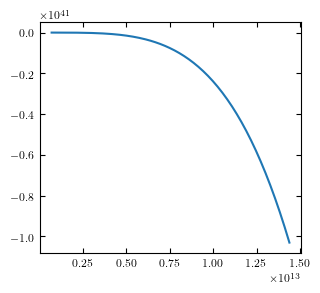

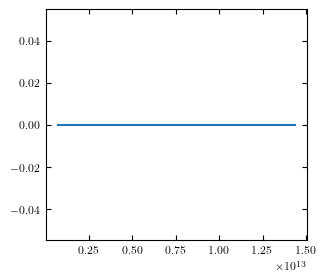

In [28]:
plt.plot(rvals, f1vals)
plt.show()

plt.plot(rvals, f2vals)
plt.show()

In [29]:
# Make comparison for M33-X7

lgmrange = np.arange(-14, -10, 0.05)

pex_m33x7 = [get_excl_prob(10**lgm, 'M33 X-7', states, out=False) for lgm in tqdm(lgmrange)]
pex_m33x7 = np.array(pex_m33x7)
pex_m33x7_masha = np.array([test_for_index(0, lgm, -18) for lgm in lgmrange])

  0%|          | 0/80 [00:00<?, ?it/s]

In [30]:
from scipy.stats import chi2
from scipy.interpolate import interp1d 
from scipy.integrate import quad

#print(chi2.ppf(0.9545, df=1))
marg_ll = interp1d(lgmrange, 1-0.01*pex_m33x7[:,0])
post_norm, post_norm_err = quad(lambda x: marg_ll(x), -13.9, -10.1)
print(post_norm, post_norm_err)

1.8710300171996157 5.282869147937852e-05


/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_33400/1607901714.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  post_norm, post_norm_err = quad(lambda x: marg_ll(x), -13.9, -10.1)


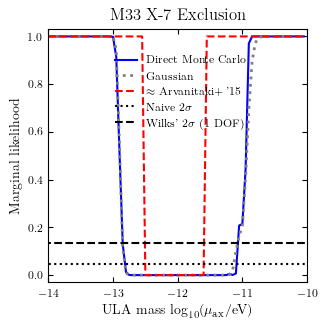

In [31]:
"""
fig, ax = plt.subplots()
ax.plot(lgmrange, 0.01*(pex_m33x7[:,0]-pex_m33x7[:,2]), 'b-', label='Full')
ax.plot(lgmrange, 0.01*(pex_m33x7[:,1]-pex_m33x7[:,2]), 'r--', label='Gaussian')
ax.plot(lgmrange, pex_m33x7_masha-0.01*pex_m33x7[:,2], 'k:', label="Masha++")
#ax.plot(lgmrange, pex_m33x7[:,2]/100 - pex_matt[:,1], 'orange', label=r"Matt's code")
ax.set_title('M33-X7')
ax.set_xlabel(r'ULA mass $\mu_\text{ax}$')
ax.set_ylabel("Excl. prob. - Matt\'s result")
ax.set_ylim([-1,1])
ax.legend()
plt.show()
""";

fig, ax = plt.subplots(figsize=(3.375,3.375))

#ax.plot(lgmrange, 1-0.01*pex_m33x7[:,2], c='purple', ls='--', label=r"Stott + Marsh '18")
ax.plot(lgmrange, 1-0.01*pex_m33x7[:,0], 'b-', label="Direct Monte Carlo")
ax.plot(lgmrange, 1-0.01*pex_m33x7[:,1], c='grey', ls=':', lw=2, label="Gaussian")
ax.plot(lgmrange, 1-pex_m33x7_masha, 'r--', label=r"$\approx$ Arvanitaki+ '15")
ax.plot([-16,-8], 2*[1-0.9545], 'k:', label=r"Naive $2\sigma$")
ax.plot([-16,-8], 2*[np.exp(-0.5*4)], 'k--', label=r"Wilks' $2\sigma$ (1 DOF)")

ax.set_title('M33 X-7 Exclusion')
ax.set_xlabel(r"ULA mass $\log_{10}(\mu_\text{ax}/\text{eV})$")
ax.set_ylabel("Marginal likelihood")
ax.set_xlim([-14,-10])
ax.set_ylim([-0.03,1.03])
ax.legend(loc='center', bbox_to_anchor=(0.51,0.75))
fig.tight_layout()
fig.savefig("figures/marginal_likelihood.pdf", backend='pgf')
plt.show()